# Final Assignment: Predictive Model #
#### This assignment is mainly to use linear regression and random forest to predict the logarithm of the number of sales based on the key indicators such as price, rating, frequency of occurrence of high-frequency words in the product title, etc. ####

For this assignment I will scrape data from *Aliexpress (www.aliexpress.com)*. AliExpress is an online retail service based in China owned by the Alibaba Group. It is one of the biggest online retail platform over the world.
According to research, I chose "phone case" for the predicted product because "phone case" won the most popular product on the Aliexpress platform in 2020. Therefore, In such a highly competitive market, how to attract more users by optimizing product titles to increase sales is the primary purpose of this model.

In [659]:
import sklearn as sk
import pandas as pd
import numpy as np
import math

#For making plots
import seaborn as sns
import matplotlib.pyplot as plt

#For extract & remove stopwords from the title 
from nltk.corpus import stopwords

#Train and test data
from sklearn.model_selection import train_test_split

#For creating Linear regression model
from sklearn.linear_model import LinearRegression

#For creating Random Forest model
from sklearn.ensemble import RandomForestRegressor

#For checking the performance of Linear regression model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### Read CSV file ####
The process of data scraping and data cleaning can be found in the files of *'aliexpress.py'* and *'aliexpress_cleaning.py'*. 

I scraped a total of 6 variables, they are *'title', 'price', 'rating', 'number_sold', 'if_is_free_shipping' and 'store'*. n=328

In [660]:
df = pd.read_csv('aliexpress_new.csv') #read csv file
print(df.head())

                                               title  price  rating  \
0  For iPhone 7 6 6S 8 Plus Case Luxury Original ...   1.26     4.8   
1  New Original Liquid Silicone Soft Case For Sam...   0.01     4.7   
2  Clear Phone Case For iPhone 11 7 8 XR Case Sil...   0.70     4.8   
3  Candy Color Silicone Phone Case For samsung ga...   0.01     4.8   
4  Original Internet  Celebrity Fidget Toys Phone...   2.99     5.0   

   number_sold  if_is_free_shipping                 store  
0      70624.0                    1           MBAND Store  
1      47979.0                    0  YISHANGOU Shop Store  
2       3627.0                    1      LZD Global Store  
3       6824.0                    1          STAR-Q Store  
4         43.0                    1         TOM-CAT Store  


#### Cleaning Dataset ####
In order to add more correlation variables to improve the accuracy of the predictive model, the first step is to clean the data.

First of all, in order to accurately capture the high-frequency words in the title, I need to remove stop words *(stop words are words which are filtered out before or after processing of natural language data, such as'for','is' etc)* , So I first convert the words in the title to lowercase. It can be seen from the column ‘stopwords’ that there are at least 1-2 stop words in the existing product titles. Therefore, I extracted these words and remove them from the title by using split() function.

Meanwhile, I also added ‘title_count’ and ‘numerics’ columns respectively to view the number of words and the number of digits in the title.

Let's see the head of dataframe

In [661]:
df['title'] = df['title'].str.lower() #transform title into lower case
df['title_count'] = df['title'].apply(lambda x: len(str(x).split(" "))) #create the column with number of words in the title
df['numerics'] = df['title'].apply(lambda x: len([x for x in x.split() if x.isdigit()])) #create the column with number of digits in the title
stop = stopwords.words('english') #define stopwords language as english 
df['stopwords'] = df['title'].apply(lambda x: len([x for x in x.split() if x in stop])) #create the stopwords column to see if title contains stopwords
df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #remove stopwords
print(df.head())

                                               title  price  rating  \
0  iphone 7 6 6s 8 plus case luxury original liqu...   1.26     4.8   
1  new original liquid silicone soft case samsung...   0.01     4.7   
2  clear phone case iphone 11 7 8 xr case silicon...   0.70     4.8   
3  candy color silicone phone case samsung galaxy...   0.01     4.8   
4  original internet celebrity fidget toys phone ...   2.99     5.0   

   number_sold  if_is_free_shipping                 store  title_count  \
0      70624.0                    1           MBAND Store           26   
1      47979.0                    0  YISHANGOU Shop Store           26   
2       3627.0                    1      LZD Global Store           31   
3       6824.0                    1          STAR-Q Store           24   
4         43.0                    1         TOM-CAT Store           22   

   numerics  stopwords  
0         5          2  
1         0          1  
2         9          2  
3         0          1  
4  

After processing the title data, I listed the most frequently occurring keyword in the title.

In [662]:
frequent_word = pd.Series(' '.join(df['title']).split()).value_counts()[:10] #extract frequency keywords from title
print(frequent_word)

case        557
cover       335
phone       295
soft        183
silicone    153
tpu         137
back        128
samsung     121
pro         115
huawei      105
dtype: int64


Now, I will create new columns of these high-frequency words to show the number of times they appear in each title.

I have also created 'the logarithm number of sales' column for resulting a better prediction model.

In [663]:
df['if_contain_case'] = df.title.str.count("case") #if word 'case' contains in the title and the number of times it appears
df['if_contain_cover'] = df.title.str.count("cover") #if word 'cover' contains in the title and the number of times it appears
df['if_contain_phone'] = df.title.str.count("phone") #if word 'phone' contains in the title and the number of times it appears
df['if_contain_soft'] = df.title.str.count("soft") #if word 'soft' contains in the title and the number of times it appears
df['if_contain_silicone'] = df.title.str.count("silicone") #if word 'silicone' contains in the title and the number of times it appears
df['if_contain_tpu'] = df.title.str.count("tpu") #if word 'tpu' contains in the title and the number of times it appears
df['if_contain_back'] = df.title.str.count("back") #if word 'back' contains in the title and the number of times it appears
df['if_contain_samsung'] = df.title.str.count("samsung") #if word 'samsung' contains in the title and the number of times it appears
df['if_contain_pro'] = df.title.str.count("pro") #if word 'pro' contains in the title and the number of times it appears
df['if_contain_huawei'] = df.title.str.count("huawei") #if word 'huawei' contains in the title and the number of times it appears
df = df.dropna(axis=0) #drop rows containing NaN
df = df.drop(['stopwords'], axis=1) #drop 'stopwords' columns because there's no values after i removed all the stop words
df['sales_log'] = np.log(df['number_sold'].to_numpy()) #create the log number of sales for predictive model 
print(df.head())

                                               title  price  rating  \
0  iphone 7 6 6s 8 plus case luxury original liqu...   1.26     4.8   
1  new original liquid silicone soft case samsung...   0.01     4.7   
2  clear phone case iphone 11 7 8 xr case silicon...   0.70     4.8   
3  candy color silicone phone case samsung galaxy...   0.01     4.8   
4  original internet celebrity fidget toys phone ...   2.99     5.0   

   number_sold  if_is_free_shipping                 store  title_count  \
0      70624.0                    1           MBAND Store           26   
1      47979.0                    0  YISHANGOU Shop Store           26   
2       3627.0                    1      LZD Global Store           31   
3       6824.0                    1          STAR-Q Store           24   
4         43.0                    1         TOM-CAT Store           22   

   numerics  if_contain_case  if_contain_cover  if_contain_phone  \
0         5                2                 1              

So the above is my final dataset, it contains 19 variables in total, including 17 numerical variables.

**Data key:**

1. **title** - Product(phone case) title
2. **price** - Product price per unit
3. **rating** - the overall score about the product from customer side
4. **number_sold** - the number of the products have been sold
5. **if_is_free_shipping** - if the product is free shipping (0:not free shipping; 1:is free shipping)
6. **store** - store name of seller
7. **title_count** - the number of words in the title
8. **numerics** - the number of digits in the title
9. **if_contain_case** - the number of times of the keyword 'case' appear in the title
10. **if_contain_cover** - the number of times of the keyword 'cover' appear in the title
11. **if_contain_phone** - the number of times of the keyword 'phone' appear in the title
12. **if_contain_soft** - the number of times of the keyword 'soft' appear in the title
13. **if_contain_silicone** - the number of times of the keyword 'silicone' appear in the title
14. **if_contain_tpu** - the number of times of the keyword 'tpu' appear in the title
15. **if_contain_back** - the number of times of the keyword 'back' appear in the title
16. **if_contain_samsung** - the number of times of the keyword 'samsung' appear in the title
17. **if_contain_pro** - the number of times of the keyword 'pro' appear in the title
18. **if_contain_huawei** - the number of times of the keyword 'huawei' appear in the title
19. **sales_log** - the logarithm of sales

#### Descriptive analysis ####
In order to explore more in the data set, I am going to make some plots to further analyze the data.

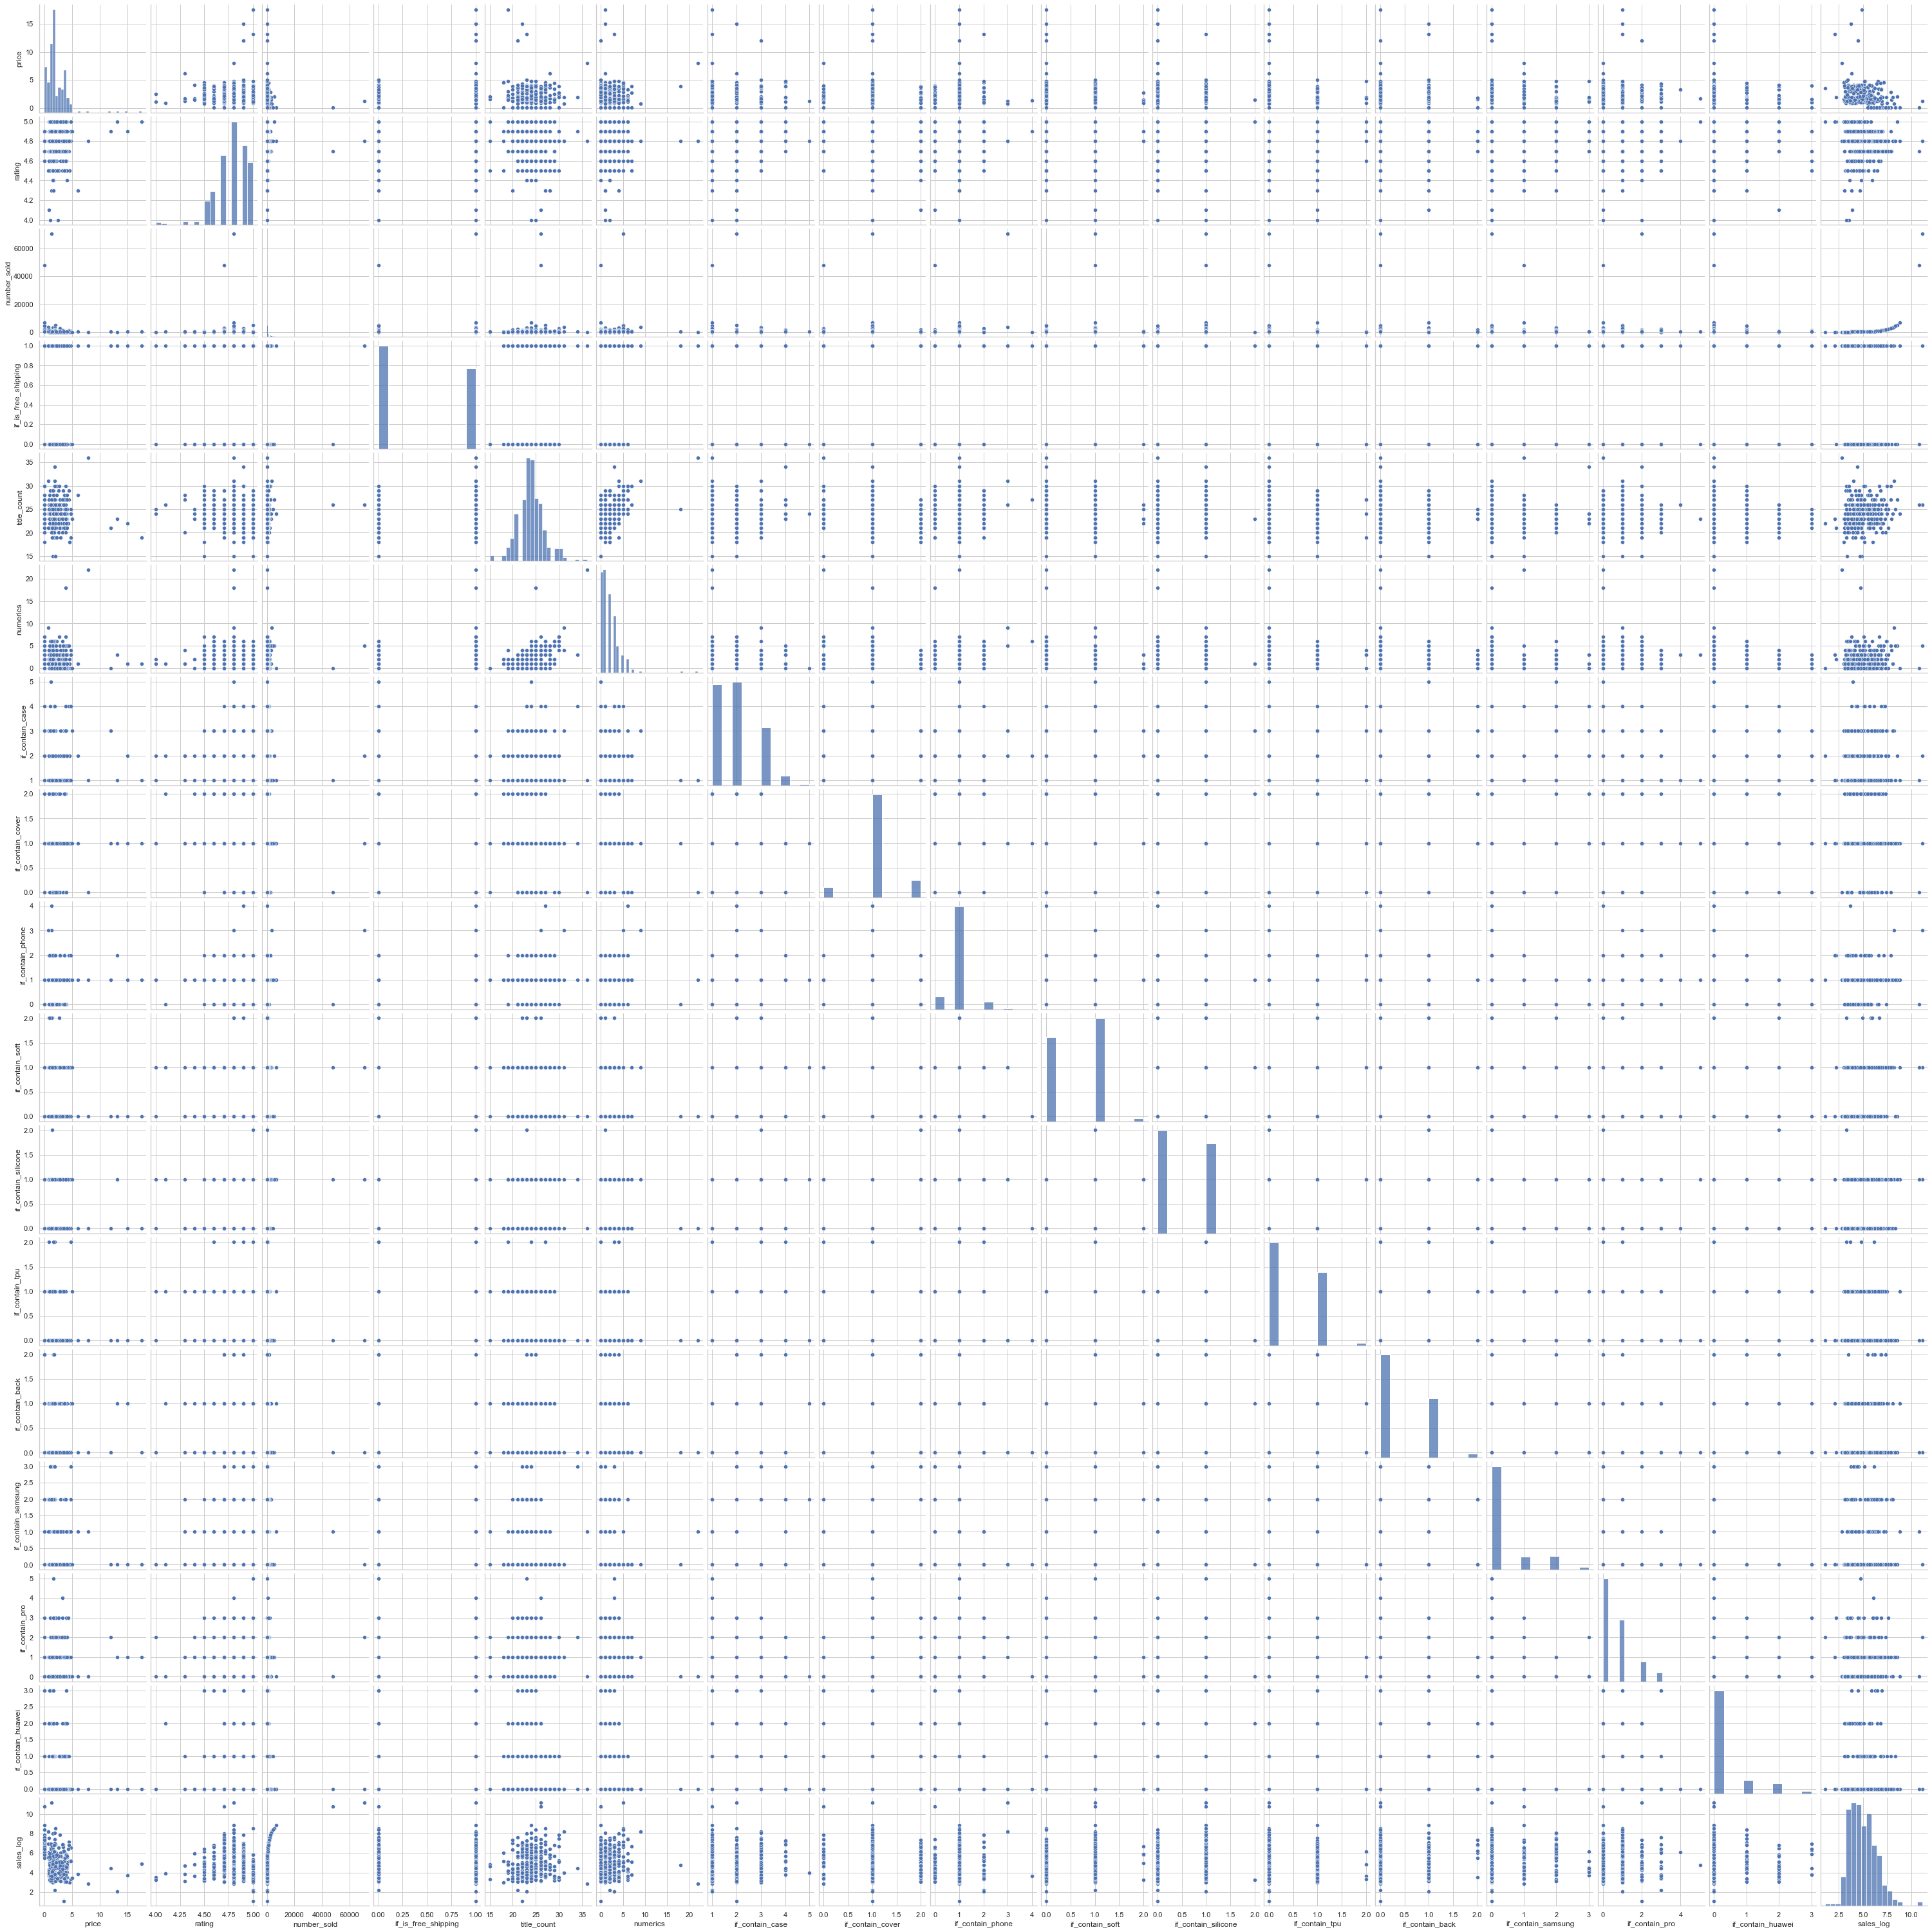

In [664]:
sns.pairplot(df) #use scatterplot matrix to see if there's any abnormal datas 
plt.show()

In order to see if there's any correlation between those variables, I have therefore made scatterplots.
From the matrix I can see that:
1. There's sales of two specific products are extremely high, standing roughly 70,000 and 50,000 respectively. However, after considering, I decided not to remove these two 'abnormal' data as the main goal for this predictive model is to predict sales data through the high-frequency vocabulary of the title to provide businesses with headline optimization suggestions, so I think these two high-selling products are also an indispensable part of the model.
2. Most phone cases are priced between 0-5 euros, but there are also a few products that cost more than 10 euros.
3. Rating has nothing to do with price. Most products have ratings above 4.5, including both low- and high-priced products.


The mean log of sales is: 4.9872279497190375
The median log of sales is: 4.804021044733257


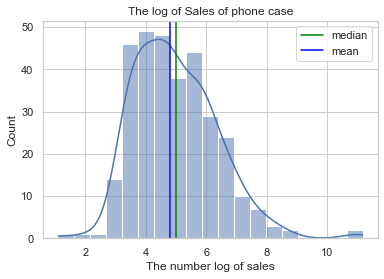

In [665]:
mean_log_sales = df['sales_log'].mean() #calculate the mean 
median_log_sales = df['sales_log'].median() #calculate the median

print(f'The mean log of sales is: {mean_sales}' ) 
print(f'The median log of sales is: {median_sales}' )

sns.histplot(df['sales_log'], kde=True) #Make histplot
plt.title('The log of Sales of phone case') #add title
plt.axvline(mean_log_sales, 0, 12, color='green', label='median') #add a vertical line at x-position median_size, from x = 0 to x = 20000 
plt.axvline(median_log_sales, 0, 12 , color='blue', label='mean') #add a vertical line at x-position mean_size, from x = 0 to x = 20000 
plt.xlabel('The number log of sales') #add x label
plt.ylabel('Count')# add y label
plt.legend() 
plt.show()

The histplot above gives us a big picture of the log of sales variable, from this plot it can be seen that the mean log of sales is 4.99 and the median log of sales is 4.80

In order to observe whether the number of occurrences of high-frequency words has a certain relationship with sales, I used violinplot and boxplot to further analyze two different keywords (‘case’ and ‘back’) 

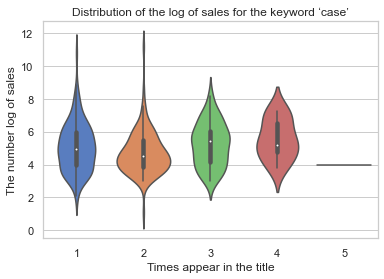

In [666]:
sns.set_theme(style="whitegrid") #set plot theme
sns.violinplot(x="if_contain_case", y="sales_log",data=df, palette="muted", split=True) #create violinplot
plt.title('Distribution of the log of sales for the keyword ‘case’') #add title
plt.xlabel('Times appear in the title') #add x label
plt.ylabel('The number log of sales') #add y label
plt.show()

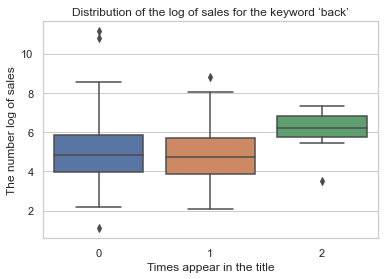

In [667]:
sns.boxplot(x="if_contain_back", y="sales_log", data=df) #create boxplot
plt.title('Distribution of the log of sales for the keyword ‘back’') #add title
plt.xlabel('Times appear in the title') #add x label
plt.ylabel('The number log of sales') #add y label
plt.show()

From violinplot the sales of the keyword ‘case’ that appears 3-4 times in the same title is higher than the frequency that appears 1-2 times. Similar result as Boxplot. The sales where the keyword ‘back’ appears three times is greater than the sales that appears 1-2 times.

To summarize. This consequent can indirectly prove that there may be a positive correlation between the frequency of keywords in the title and sales.

In addition, to explore more correlation between these variables, I made a heatmap below. Let's have a close look among them.

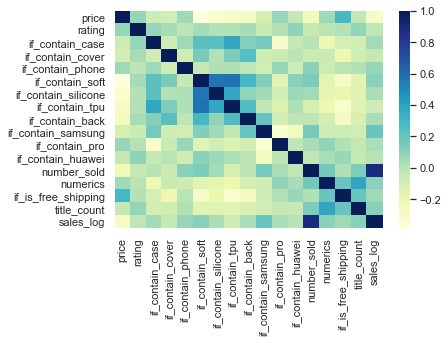

In [668]:
sns.heatmap(corr, xticklabels = corr.columns, yticklabels= corr.columns, cmap='YlGnBu')
plt.show()

In this heatmap, it can be seen that there are also some relationships between keywords. 
- If the keyword "soft" appears in the title, there is a high probability that "silicone" and "tpu" will also include, which makes sense, because silicone and tpu are a relatively soft raw material, so the three of them are easy to be edited in the same title.
- There also seems to be a slight correlation between'price' and 'if_is_free_shipping'. This may tell us that the higher the price of the product, the more likely it is to be free shipping.
- The more words in the title(title_count), the digits(numerics) may increase accordingly. This may be due to the mobile phone brand and the type of phone always appearing together (for example: iphone 12)

#### Spliting the data ####
Before building a model, I need to determine x (independent variable) and y (dependent variable/predicted value).
- x variables: All the variables except for the log of sales and number of products sold
- y variable: The log of sales

*Note: Since the model can only recognize numbers, I will reorder the dataframe in order to exclude ‘store’ and ‘number_sold’ in the x variables before building the model*

In [669]:
df = df[['title','price','rating','if_is_free_shipping','title_count','numerics','if_contain_case','if_contain_cover','if_contain_phone','if_contain_soft','if_contain_silicone','if_contain_tpu','if_contain_back','if_contain_samsung','if_contain_pro','if_contain_huawei','store','number_sold','sales_log']]
y = df['sales_log'] #take shares_log as Y-variable
X = df.loc[:, 'price':'if_contain_huawei'] #include all rows and the columns from "price" to "if_contain_huawei"
X.index = df['title'] #set index as article title
X.head()

,price,rating,if_is_free_shipping,title_count,numerics,if_contain_case,if_contain_cover,if_contain_phone,if_contain_soft,if_contain_silicone,if_contain_tpu,if_contain_back,if_contain_samsung,if_contain_pro,if_contain_huawei
title,,,,,,,,,,,,,,,
iphone 7 6 6s 8 plus case luxury original liquid silicone soft cover iphone 11 12 pro x xr xs max shockproof phone case,1.26,4.8,1,26,5,2,1,3,1,1,0,0,0,2,0
new original liquid silicone soft case samsung a51 a50 s10 plus s8 s9 s20 fe s21 plus ultra s10e a71 a70 a21s a31 a41 coque,0.01,4.7,0,26,0,1,0,0,1,1,0,0,1,0,0
clear phone case iphone 11 7 8 xr case silicone soft cover iphone 11 12 mini pro xs max x 8 7 6s plus 5 se 2020 xr case,0.70,4.8,1,31,9,3,1,3,1,1,0,0,0,1,0
candy color silicone phone case samsung galaxy a12 a42 a52 a72 a32 5g m02s a02s m31s matte soft tpu back cover fundas coque,0.01,4.8,1,24,0,1,1,1,1,1,1,1,1,0,0
original internet celebrity fidget toys phone case xiao mi iphone 116.1inchese 12 pro max xr xs 7 8g&plus shockproof cover,2.99,5.0,1,22,2,1,1,2,0,0,0,0,0,2,0


Now i split the data into a training set and a test set.

In [670]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables
X_train.head() #The train data

,price,rating,if_is_free_shipping,title_count,numerics,if_contain_case,if_contain_cover,if_contain_phone,if_contain_soft,if_contain_silicone,if_contain_tpu,if_contain_back,if_contain_samsung,if_contain_pro,if_contain_huawei
title,,,,,,,,,,,,,,,
samsung galaxy a01 core back case silicon back cover phone cases samsung a01 core sm-a013 soft case 5.45 inch mobie case,1.74,4.9,0,23,0,4,1,1,1,0,0,2,2,0,0
popular case samsung galaxy s20 fe case soft silicone back cover phone case funda samsung s20 fe 5g case s20 plus case,1.21,4.8,0,24,0,5,1,1,1,1,0,1,2,0,0
cover asus zenfone 3 ze552kl case anti-knock heavy duty armor cover silicone phone bumper case asus zenfone 3 ze552kl <,2.58,4.8,1,22,2,2,2,1,0,1,0,0,0,0,0
hybrid rugged armor pc + tpu silicone shockproof case oneplus 8t 8 7 7t 9 pro 1+nord n10 5g n100 soft frame hard back cover,3.35,4.6,1,26,3,1,1,0,1,1,1,1,0,2,0
luxury leather flip book case zte blade v7 lite v7 max rose flower wallet stand case phone cover bag,3.89,4.9,1,20,0,2,1,1,0,0,0,0,0,0,0


#### Training the Linear regression model ####
For the numerical value i will first use linear regression model and use training data to fit the model

In [671]:
lm = LinearRegression() #create the linear regression model
model = lm.fit(X_train, y_train) #train the model

Let's have a close look of the coefficients

In [672]:
coef = pd.DataFrame(X.columns.values, lm.coef_) #this creates a df with a column with the column names, and the coefficients of the model
coef

,0
-0.193272,price
-0.238593,rating
0.261363,if_is_free_shipping
0.031412,title_count
-0.002692,numerics
0.036864,if_contain_case
-0.444543,if_contain_cover
-0.087429,if_contain_phone
0.216470,if_contain_soft
-0.122928,if_contain_silicone


We can interpret these coefficients as follows:

1. For every 10 cents increase in **price**, the logarithm of the number of sales would <span style='color:Red'> decrease 0.193 </span>
2. For every 0.1 points increase in **rating**, the logarithm of the number of sales would <span style='color:Red'> decrease 0.239 </span>
3. **Free shipping** for each additional item, the logarithm of the number of sales would <span style='color:Green'> increase 0.261 </span>
4. **Every extra words** in the title would <span style='color:Green'> increase 0.031 </span> the logarithm of the number of sales
5. **Every extra digits** in the title would <span style='color:Red'> decrease 0.003 </span> the logarithm of the number of sales
6. When keyword **'case'** is included in the title, the logarithm of the number of sales would <span style='color:Green'> increase 0.037 </span>
7. When keyword **'cover'** is included in the title, the logarithm of the number of sales would <span style='color:Red'> decrease 0.445 </span>
8. When keyword **'phone'** is included in the title, the logarithm of the number of sales would <span style='color:Red'> decrease 0.087 </span>
9. When keyword **'soft'** is included in the title, the logarithm of the number of sales would <span style='color:Green'> increase 0.216 </span>
10. When keyword **'silicone'** is included in the title, the logarithm of the number of sales would <span style='color:Red'> decrease 0.123 </span>
11. When keyword **'tpu'** is included in the title, the logarithm of the number of sales would <span style='color:Red'> decrease 0.312 </span>
12. When keyword **'back'** is included in the title, the logarithm of the number of sales would <span style='color:Red'> decrease 0.012 </span>
13. When keyword **'samsung'** is included in the title, the logarithm of the number of sales would <span style='color:Green'> increase 0.233 </span>
14. When keyword **'pro'** is included in the title, the logarithm of the number of sales would <span style='color:Green'> increase 0.069 </span>
15. When keyword **'huawei'** is included in the title, the logarithm of the number of sales would <span style='color:Green'> increase 0.101 </span>


#### Evaluating the predictive model ####
Now it's time to calculate the R^2 and RMSE see how good the fits(goodness of fit) by using test data.

In [673]:
y_test_pred = lm.predict(X_test) #Generate predictions for the test data. So use X.test
r2_test = r2_score(y_test, y_test_pred)
print(f"The R^2 = {r2_test}")

The R^2 = 0.11334991059898958


This linear predictive model fits the model poorly. The **R^2** is 0.113, which means 11.3% of the varibility of the log number of sales is explained by the model.

After calculating R^2, we will take the **RMSE** to see how much the model is off

In [674]:
rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"The RMSE = {rmse}")

The RMSE = 1.3325211044598404


The RMSE is 1.26. Which means that we are typically about 1.33 off in our predicted the log number of sales 

#### Training the Random Forest model ####
Now i will use another model to see if I could get a better fit of model. Let's train the Random Forest algorithm. 

RF uses randomness, I've already created the train and test data, so I just need to set a random_state for the stable result for presentation purposes. And i've also set n_estimators(the number of the trees) we use for the model.

In [675]:
rf = RandomForestRegressor(random_state=1, n_estimators=20) #RF is a random algorithm, so to get the same results we need to use random_state
rf_model = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#### Evaluating the predictive model ####

In [676]:
r2_test_2 = r2_score(y_test, y_pred)
print(f"The R^2 = {r2_test_2}")

The R^2 = 0.27419701553001385


The RF model seems to get better results than the linear regression model, although the R^2 value is still quite low. The **R^2** is standing 0.274, which means 27.4% of the varibility of the log number of sales is explained by the RF model.

Let's also have a close look of **RMSE**

In [677]:
RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"The RMSE = {RMSE}")

The RMSE = 1.2056113831282378


The RMSE is 1.206. We therefore can conclude that the RF model predicts about 1.206 off of the log number of sales

#### Evaluation ####
Now it's time to plot the predicted the log number of sales against the actual shares_log. In order to see the differences between these two models and pick up the one which fits the most, I have made two plots (graph 1 is Linear regression model and graph 2 is Random forest model)

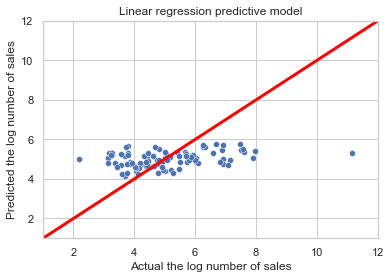

In [678]:
sns.scatterplot(x=y_test, y=y_test_pred)
plt.title('Linear regression predictive model') #add title
plt.xlabel('Actual the log number of sales')
plt.ylabel('Predicted the log number of sales')
plt.xlim([1,12]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.ylim([1,12])
plt.plot([1, 12], [1, 12], color='red', lw=3) #Plot a diagonal length
plt.show()

The first plot(Linear regression model) it can be seen that because of the lower R Square, the Predictive model seems pretty weak, most points are far away from the diagonal. 

From this plot it seems to have three subsections of performance: 
- The first one is where Actuals have values between 3 and 4, within this zone, my model steadily slightly overestimated. 
- The second one is when Actuals are between 4 and 6, within this zone, the model does not seem too bad. 
- The last one is where Actuals have values between 6 and 8, within this zone, my model steadily slightly underestimates the Actual values.

Besides, there's two values seems extreme far away from the line, one is where actual value is 2 but the model predicted 5; another is where actual value is 11 however the model predicted 5. I think this may be related to the over-sales or under-sales of certain products.

Then let's have a look of RF model plots below.


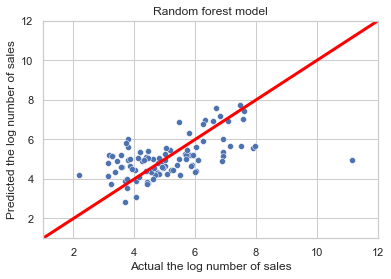

In [679]:
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Random forest model') #add title
plt.xlabel('Actual the log number of sales')
plt.ylabel('Predicted the log number of sales')
plt.xlim([1,12]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.ylim([1,12])
plt.plot([1, 12], [1, 12], color='red', lw=3) #Plot a diagonal length
plt.show()

Compared with the linear regression model, RF model seems have a better performance.
Therefore, we can conclude that for some values the RF model a bit overshoots (predicts too high) for low log numbers of sales, and undershoots for high log numbers of sales (predicts too low).

Similar like the linear regression model, there's also two 'abnomal' values in the plot, same reason mentioned above.

To conclusion, Random forest model fits the best for now.

Now let's make plots of the residuals by using RF model.

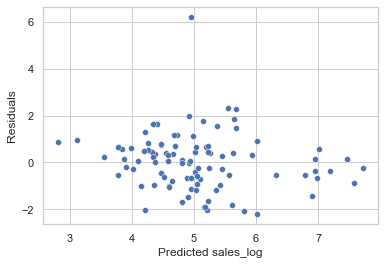

In [680]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred,y=residuals)
plt.xlabel('Predicted sales_log')
plt.ylabel('Residuals')
plt.show()

As we can see, the residual is at a relatively stable level with increasing the log of sales. Therefore, this proves again that the RF model is more suitable.

#### Conclusion ####
After evaluating the Linear regression model and Random forest model separately, it can be concluded that the RF model with R^2 of 0.27 and RMSE of 1.206 is more fit. However, even with the better performance, the model still has an overall poor fitting. This may be due to other factors affecting sales, such as Aliexpress's irregular coupon activities, etc.

However, based on the current analysis and predictive model. I have some suggestion for the sellers:
- Increase the frequency of high-frequency keywords in the title. For example, instead of mentioning ‘back’ in the title only once, it can be used multiple times instead in the same title.
- When mentioning keywords with "soft" in the title, it is recommended to also add "silicone" and "tpu" in it.
- Mentioning the mobile phone brand and type of the phone in the title at the same time may also increase sales. For instance:iphone 12, Samsung s21 etc.
- When selling high-priced mobile phone cases (price above 10 euros for example), it is recommended to provide free shipping.
- Selling Samsung, (X) pro and Huawei mobile phone cases has a greater chance of increasing sales.